In [13]:
import numpy as np
import random as rnd
import os
import re
from IPython.display import HTML, display
import matplotlib.pyplot as plt

In [14]:
languages = ['nodejs', 'java_8_hotspot', 'go', 'posix', 'arduino_due']
log_modes = ['monitor', 'monitor-bin', 'monitor-bin_string']
modes = ['no', 'off', 'on']
fig_counter = 0
root='../../../src-gen/logs'

In [15]:
def allFiles(language, mode, log_mode):
    directory = os.fsencode(root + '/' + log_mode + '/' + mode)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.split('.')[0].startswith(language) and filename.endswith('.log'): 
            yield root + '/' + log_mode + '/' + mode + '/' + filename
            
def loadMemory(filename, language):
    file = open(filename)
    while True:
        try:
            line = file.readline()      
            if not line:
                break
            if '>usedMem:' in line:
                mem = int(line.strip().split(':')[-1])
                yield mem   
        except:
            yield 0
            
def loadTotalTime(filename):
    file = open(filename)
    while True:
        try:
            line = file.readline()      
            if not line:
                break                  
            if '>done in ' in line:
                time = int(line.split('>')[1][8:-4])
                yield time
        except:
            yield 0

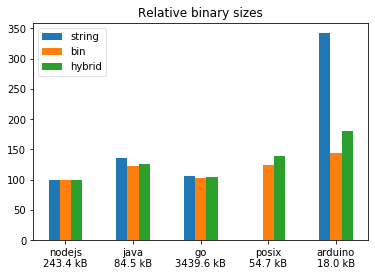

In [16]:
def allData(language, mode, log_mode):
    all_mem = []
    all_t = []
    for filename in allFiles(language, mode, log_mode):
        mem = np.array(list(loadMemory(filename, language))).astype(int).flatten()
        t = np.array(list(loadTotalTime(filename)))
        all_mem.append(mem)
        all_t.append(t)
    return np.average(np.array(all_mem)), np.average(np.array(all_t))

def allStaticData(language):
    all_bin = []
    file = open(root + '/log.cloc')
    while True:
        line = file.readline()      
        if not line:
            break                  
        if language in line:            
            bin = 0
            if ':bin:' in line:
                try:
                    bin = int(line.split(':bin:')[1])
                except:
                    bin = 0
                all_bin.append(bin)            
    return all_bin

all_bin = []
y_bin = []
m = ['no', 'string', 'bin', 'hybrid']
for language in languages:
    bin = allStaticData(language)    
    all_bin.append(np.round(np.array(bin)/bin[0]*100,0))
    y_bin.append(language.split('_')[0] + '\n' + str(np.round(bin[0]/1000,1)) + ' kB')

data = np.array(all_bin)
x = np.arange(data.shape[0])
dx = (np.arange(data.shape[1])-data.shape[1]/2.)/(data.shape[1]+2.)
d = 1./(data.shape[1]+2.)
fig, ax=plt.subplots()
for i in range(data.shape[1]):
    if i == 0:
        continue
    ax.bar(x+dx[i],data[:,i], width=d, label=""+m[i])
plt.xticks(np.arange(len(y_bin)), (y_bin[0], y_bin[1], y_bin[2], y_bin[3], y_bin[4])) 
plt.legend(framealpha=100)
plt.title('Relative binary sizes')
plt.show()

C:\Users\brice\Miniconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\brice\Miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


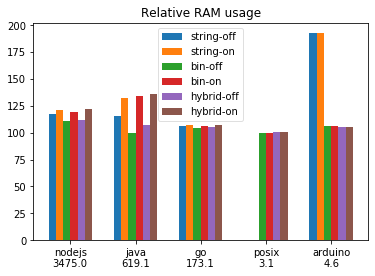

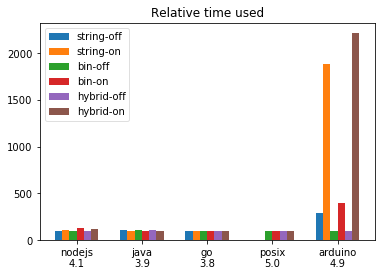

In [17]:
all_t = []
all_mem = []
for language in languages:     
    all_t_language = []
    all_mem_language = []
    for log_mode in log_modes:       
        hasError = False
        for mode in modes:
            if mode == 'no' and not log_mode == "monitor":
                continue
            try:
                mem, t = allData(language, mode, log_mode)                
                all_t_language.append(t)
                all_mem_language.append(mem)                
            except TypeError:
                hasError = True
                break        
        if hasError:
            continue
    all_t.append(all_t_language)
    all_mem.append(all_mem_language)
            
data = np.array(all_mem)
data_t = all_t


m = ['no', 'string-off', 'string-on', 'bin-off', 'bin-on', 'hybrid-off', 'hybrid-on' ]
x = np.arange(data.shape[0])
dx = (np.arange(data.shape[1])-data.shape[1]/2.)/(data.shape[1]+2.)
d = 1./(data.shape[1]+2.)
fig, ax=plt.subplots()
for i in range(data.shape[1]):
    if i == 0:
        continue    
    ax.bar(x+dx[i],data[:,i]/data[:,0]*100, width=d, label=""+m[i])
plt.xticks(np.arange(data.shape[0]), (languages[0].split('_')[0]+'\n'+str(np.round(data[0,0]/1000,1)), languages[1].split('_')[0]+'\n'+str(np.round(data[1,0]/1000,1)), languages[2].split('_')[0]+'\n'+str(np.round(data[2,0]/1000,1)), languages[3].split('_')[0]+'\n'+str(np.round(data[3,0]/1000,1)), languages[4].split('_')[0]+'\n'+str(np.round(data[4,0]/1000,1)))) 
plt.legend(framealpha=100)
plt.title('Relative RAM usage')
plt.show()


data = np.array(all_t)
x = np.arange(data.shape[0])
dx = (np.arange(data.shape[1])-data.shape[1]/2.)/(data.shape[1]+2.)
d = 1./(data.shape[1]+2.)
fig, ax=plt.subplots()
for i in range(data.shape[1]):
    if i == 0:
        continue      
    ax.bar(x+dx[i],data[:,i]/data[:,0]*100, width=d, label=""+m[i])
plt.xticks(np.arange(data.shape[0]), (languages[0].split('_')[0]+'\n'+str(np.round(data[0,0]/1000,1)), languages[1].split('_')[0]+'\n'+str(np.round(data[1,0]/1000,1)), languages[2].split('_')[0]+'\n'+str(np.round(data[2,0]/1000,1)), languages[3].split('_')[0]+'\n'+str(np.round(data[3,0]/1000,1)), languages[4].split('_')[0]+'\n'+str(np.round(data[4,0]/1000,1)))) 
plt.legend(framealpha=100)
plt.title('Relative time used')
plt.show()    